In [1]:
import pandas as pd
import numpy as np
import re
from multiprocessing import Pool
%matplotlib inline

## Read the raw file

In [2]:
df = pd.read_csv('emails.csv')

In [3]:
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
df.shape

(517401, 2)

In [10]:
print(df.message.sample().iloc[0])

Message-ID: <28651738.1075857279418.JavaMail.evans@thyme>
Date: Thu, 15 Jun 2000 10:51:00 -0700 (PDT)
From: jinsung.myung@enron.com
To: aldo_portales@fpl.com, randy_hoyle@fpl.com, edward_m_bullinger@fpl.com
Subject: Model Template
Cc: don.miller@enron.com, clement.lau@enron.com, benjamin.rogers@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: don.miller@enron.com, clement.lau@enron.com, benjamin.rogers@enron.com
X-From: Jinsung Myung
X-To: aldo_portales@fpl.com, randy_hoyle@fpl.com, edward_m_bullinger@fpl.com
X-cc: Don Miller, Clement Lau, Benjamin Rogers
X-bcc: 
X-Folder: \Benjamin_Rogers_Dec2000_4\Notes Folders\Genco-jv_ipo
X-Origin: Rogers-B
X-FileName: brogers.nsf

All,

Attached is a template for a consolidated GenCo model. This model was 
designed to be high level proforma. Light yellow cells are inputs. If you 
have any question, please feel free to call me at 713-853-7330. Thank you.

Jinsung Myung
(Office) 713-853-7330

In [11]:
docs = df.message.sample(1000)
allkeys = [re.findall('\n([\w\-]+):', doc[:doc.find('\n\n')]) for doc in docs]
allkeys = sum(allkeys,[])
allkeys = set(allkeys)
allkeys.add('Message-ID')
allkeys.add('Body')

In [12]:
allkeys

{'Bcc',
 'Body',
 'Cc',
 'Content-Transfer-Encoding',
 'Content-Type',
 'Date',
 'From',
 'Message-ID',
 'Mime-Version',
 'Subject',
 'To',
 'X-FileName',
 'X-Folder',
 'X-From',
 'X-Origin',
 'X-To',
 'X-bcc',
 'X-cc'}

## Parse the documents

For each document parse into a dictionary.

In [13]:
def parse_doc(doc):
    keys = ['Message-ID']+re.findall('\n([\w\-]+):', doc[:doc.find('\n\n')])
    keys = pd.Series(keys).drop_duplicates().tolist()

    values = []
    for a, k in enumerate(keys):
        k = k+':'
        try:
            values.append(doc[doc.find(k)+len(k):doc.find(keys[a+1])].strip())
        except:
            values.append(doc[doc.find(k)+len(k):doc.find('\n\n')].strip())
    
    d = dict(zip(keys+['Body'],values+[doc[doc.find('\n\n'):].strip()]))
    k_to_remove = set(d.keys()) - set(allkeys)
    k_to_add = set(allkeys) - set(d.keys())
    
    for k in k_to_remove:
        d.pop(k)
    for k in k_to_add:
        d[k] = ''

    keys = [k[:-1] for k in keys]
    return d

In [14]:
parse_doc(df.message.sample().iloc[0])

{'Message-ID': '<24872313.1075857307180.JavaMail.evans@thyme>',
 'Date': 'Mon, 27 Mar 2000 01:42:00 -0800 (PST)',
 'From': 'chris.dorland@enron.com',
 'To': 'dianne.seib@enron.com',
 'Subject': '',
 'Mime-Version': '1.0',
 'Content-Type': 'text/plain; charset=us-ascii',
 'Content-Transfer-Encoding': '7bit',
 'X-From': 'Chris Dorland',
 'X-To': 'Dianne Seib',
 'X-cc': '',
 'X-bcc': '',
 'X-Folder': '\\Chris_Dorland_Dec2000\\Notes Folders\\Discussion threads',
 'X-Origin': 'Dorland-C',
 'X-FileName': 'cdorlan.nsf',
 'Body': "Dianne,\n\nI didn't get my spreadsheet from Friday. No biggie I just used the average of \nmy buy and sell from stack manager in my model but I would like to have the \nactual deals.\n\nThanx,\n\nChris",
 'Bcc': '',
 'Cc': ''}

Use multiprocessor

In [116]:
p = Pool(7)
dics = p.map(parse_doc, df.message)

In order to create a pandas dataframe, the keys of the dictionaries will become the columns. However, each individual value will become an array of values. We use the defaultdict to do this speedily.

In [117]:
from collections import defaultdict

dd = defaultdict(list)

for d in dics:
    for key, value in d.items():
        dd[key].append(value)
        
df_parsed = pd.DataFrame(dd)
df_parsed['file'] = df.file
df_parsed['Date_'] = pd.to_datetime(df_parsed.Date, infer_datetime_format=True)
df_parsed.to_pickle('df_parsed.pkl')

In [7]:
df_parsed = pd.read_pickle('df_parsed.pkl')

In [8]:
df_parsed.head()

,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,Body,Bcc,Cc,file,Date_
0,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast,,,allen-p/_sent_mail/1.,2001-05-14 23:39:00
1,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,,,allen-p/_sent_mail/10.,2001-05-04 20:51:00
2,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,,,allen-p/_sent_mail/100.,2000-10-18 10:00:00
3,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",,,allen-p/_sent_mail/1000.,2000-10-23 13:13:00
4,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,,,allen-p/_sent_mail/1001.,2000-08-31 12:07:00


## Cleaning / Getting rid of bad data

In [15]:
# df_parsed = pd.read_pickle('df_parsed.pkl')

In [17]:
df_parsed.set_index('Date_',inplace=True)

In [22]:
df_parsed.shape

(517401, 19)

In [18]:
df_parsed['1997':'2002'].shape  # Bulk of the data resides here

(516796, 19)

In [19]:
df_parsed[:'1996'].shape  # Remove

(524, 19)

In [20]:
df_parsed['2003':].shape  # Remove

(81, 19)

In [21]:
df_parsed.loc['1980-01-01'].shape  # Remove

(522, 19)

In [23]:
df_parsed = df_parsed['1997':'2002']

In [24]:
df_parsed.shape

(516796, 19)

## EDA

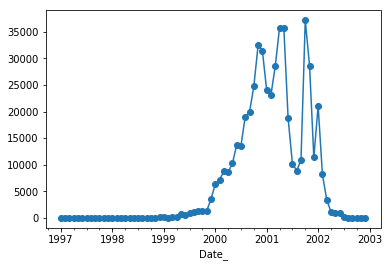

In [25]:
df_parsed.resample('MS')['Message-ID'].count().plot(marker='o')

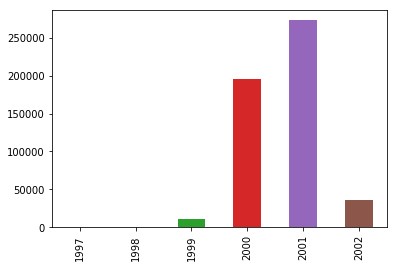

In [26]:
df_parsed.index.year.value_counts().sort_index().plot.bar()

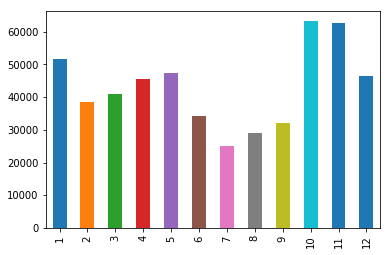

In [27]:
df_parsed.index.month.value_counts().sort_index().plot.bar()

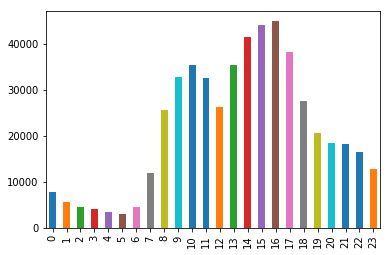

In [28]:
df_parsed.index.hour.value_counts().sort_index().plot.bar()

In [29]:
# Top 20 Froms

(lambda x: set(x[:20].index))(df_parsed['From'].value_counts())

{'chris.germany@enron.com',
 'debra.perlingiere@enron.com',
 'drew.fossum@enron.com',
 'enron.announcements@enron.com',
 'eric.bass@enron.com',
 'gerald.nemec@enron.com',
 'jeff.dasovich@enron.com',
 'john.arnold@enron.com',
 'kate.symes@enron.com',
 'kay.mann@enron.com',
 'mark.taylor@enron.com',
 'matthew.lenhart@enron.com',
 'no.address@enron.com',
 'pete.davis@enron.com',
 'sally.beck@enron.com',
 'sara.shackleton@enron.com',
 'steven.kean@enron.com',
 'susan.scott@enron.com',
 'tana.jones@enron.com',
 'vince.kaminski@enron.com'}